<a href="https://colab.research.google.com/github/iosifdaniel07/-Handwriting-to-Text-Converter-/blob/main/lstm7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From (original): https://drive.google.com/uc?id=1wuQbPcDhbamRexCchG_suXFqCqSqSbG3
From (redirected): https://drive.google.com/uc?id=1wuQbPcDhbamRexCchG_suXFqCqSqSbG3&confirm=t&uuid=ba9943c0-d792-4fc7-9537-f2a35a7f9278
To: /content/data_set_normalize.csv
100%|██████████| 3.11G/3.11G [00:09<00:00, 330MB/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
29347/29347 ━━━━━━━━━━━━━━━━━━━━ 455s 15ms/step - accuracy: 0.9905 - auc: 0.9951 - loss: 0.0330 - val_accuracy: 0.9986 - val_auc: 0.9992 - val_loss: 0.0065
Epoch 2/50
29347/29347 ━━━━━━━━━━━━━━━━━━━━ 442s 15ms/step - accuracy: 0.9984 - auc: 0.9991 - loss: 0.0075 - val_accuracy: 0.9987 - val_auc: 0.9986 - val_loss: 0.0070
Epoch 3/50
29347/29347 ━━━━━━━━━━━━━━━━━━━━ 424s 14ms/step - accuracy: 0.9986 - auc: 0.9993 - loss: 0.0065 - val_accuracy: 0.9986 - val_auc: 0.9996 - val_loss: 0.0057
Epoch 4/50
29347/29347 ━━━━━━━━━━━━━━━━━━━━ 408s 14ms/step - accuracy: 0.9987 - auc: 0.9994 - loss: 0.0058 - val_accuracy: 0.9991 - val_auc: 0.9997 - val_loss: 0.0038
Epoch 5/50
29347/29347 ━━━━━━━━━━━━━━━━━━━━ 404s 14ms/step - accuracy: 0.9988 - auc: 0.9995 - loss: 0.0052 - val_accuracy: 0.9991 - val_auc: 0.9995 - val_loss: 0.0044
Epoch 6/50
29347/29347 ━━━━━━━━━━━━━━━━━━━━ 408s 14ms/step - accuracy: 0.9989 - auc: 0.9995 - loss: 0.0050 - val_accuracy: 0.9991 - val_auc: 0.9997 - val_loss: 0.003

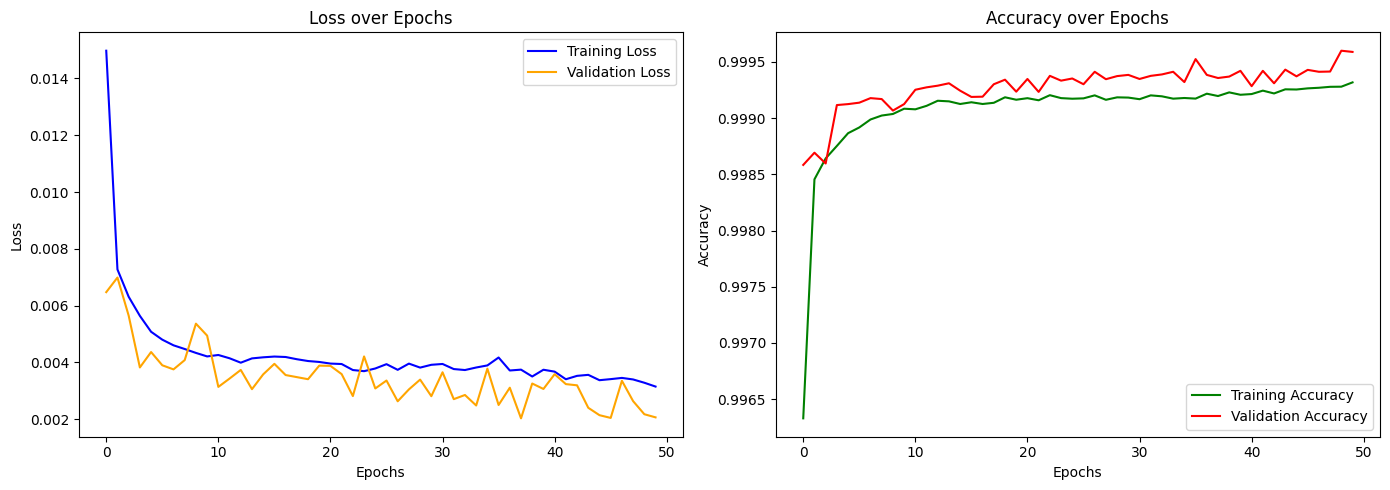

18342/18342 ━━━━━━━━━━━━━━━━━━━━ 86s 5ms/step - accuracy: 0.9995 - auc: 0.9998 - loss: 0.0024


ValueError: too many values to unpack (expected 2)

In [4]:
from google.colab import files
!pip install gdown

# -- Imports
import numpy as np
import pandas as pd
import gdown
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential
from keras.src.layers import LSTM, Dropout, Dense
from keras.src.utils import to_categorical
from keras.src.optimizers import Adam, RMSprop
from keras.src.metrics import AUC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.losses import BinaryCrossentropy

# -- Download dataset from Google Drive
file_id = "1wuQbPcDhbamRexCchG_suXFqCqSqSbG3"
url = f"https://drive.google.com/uc?id={file_id}"
output = "data_set_normalize.csv"
gdown.download(url, output, quiet=False)

# -- Load and prepare dataset
data_set = pd.read_csv('data_set_normalize.csv')
data_set.replace([np.inf, -np.inf], np.nan, inplace=True)
data_set.fillna(data_set.median(), inplace=True)

X = data_set.drop(columns=['Label'])
y = data_set['Label']

timesteps = 5

def create_sequences(data, labels, timesteps=5):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(labels[i + timesteps - 1])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(X, y, timesteps)

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, shuffle=True
)

# -- Build the model
def create_keras_model():
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(timesteps, X_train.shape[2])),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss=BinaryCrossentropy(),
        optimizer=RMSprop(),
        metrics=['accuracy', AUC()]
    )
    return model

model = create_keras_model()

# -- Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

# -- Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history_rmsp.csv', index=False)

# -- Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# -- Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# -- Predict and analyze results
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int).reshape(-1)

print(classification_report(y_test, y_pred_classes))

# -- Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# -- Optional: Save model
model.save('anomaly_detection_lstm_rmsp')